In [1]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
import IPython
import matplotlib.colors as colors

from scipy import signal
from copy import deepcopy

import utils

In [2]:
dataurl = 'http://www.openslr.org/resources/1/waves_yesno.tar.gz'

In [3]:
utils.download_and_extract_data(dataurl)

In [4]:
path_to_sound_data = './waves_yesno/'

In [5]:
### STFT hyperparameters

nperseg = 512
window_size = 5

In [6]:
noise_std_array = [1e-1];  ## all noise levels to consider. feel free to play around

In [7]:
### for plotting

ini = 34500-1
end = 37500+1

ini2 = 34875
end2 = 35025

### Creating Dataset

In [8]:
train_dataset, train_fs_array, train_max_array, val_dataset, val_fs_array, val_max_array = utils.get_data(path_to_sound_data)

train_dataset and val_dataset contains time domain signals normalized so that maximum amplitude is 1

In [9]:
max( x.max() for x in train_dataset )

1.0

The actual maximum amplitude of signal is saved in train_max_array and val_max_array. We will use this maximum value to un-normalize the signals before plotting or listening to it.

actual_signal[k] = train_dataset[k] * train_max_array[k]

The sampling rate of each sigal is given in train_fs_array and val_fs_array. In our case, all of them have same sampling rate. We will use sampling rate for stft function

### Get Noise Function 

In [10]:
def get_noise(data, noise_std = 0.1):
    noise = np.random.randn(*data.shape);
    noise = noise * noise_std;
    return noise

# STFT Hard and Block Thresholding

In [11]:
def plot_stft(stft_array, save_str=''):
    
    """ utility function to plot stft """
    f, t, Zxx = stft_array;
    Zxx_abs = np.abs(Zxx)
    Zxx_abs[Zxx_abs<1e-5] = 1e-5
    plt.figure()
    plt.pcolormesh(t, f,Zxx_abs, norm=colors.LogNorm(vmin=Zxx_abs.min(), vmax=Zxx_abs.max()),cmap='jet' )
    tick_size = 18
    label_size = 18
    cb = plt.colorbar()
    plt.tick_params(labelsize=tick_size)
    cb.ax.tick_params(labelsize=tick_size)
    plt.ylabel('Frequency (Hz)',fontsize=label_size)
    plt.xlabel('Time (s)',fontsize=label_size)
    plt.savefig('plots/stft_denoising_'+save_str+'_stft.pdf',bbox_inches="tight")
    plt.show()

In [12]:
def get_block_L2_norm(mat, window_size):
    
    """ mat: an nxn matrix
        window_size: postivie integer (assume odd)
        return: nxn matrix where the (i,j)th entry is the L2 norm of a window_size x window_size
                neighbourhood centered at (i, j)
                
        to obtain an nxn output, assume that edges are zero padded. 
        
        hint: implement using a convolution
        
        sample output for get_block_L2_norm(np.ones([5, 5]), 3): 
        
      [[2.        , 2.44948974, 2.44948974, 2.44948974, 2.        ],
       [2.44948974, 3.        , 3.        , 3.        , 2.44948974],
       [2.44948974, 3.        , 3.        , 3.        , 2.44948974],
       [2.44948974, 3.        , 3.        , 3.        , 2.44948974],
       [2.        , 2.44948974, 2.44948974, 2.44948974, 2.        ]]
    """
    
    res = signal.convolve2d(np.power(mat, 2), np.ones([window_size, window_size]), mode='same')
    res = np.power(res, 0.5)
    
   
    
    return res

### Implement Hard and Block Thresholding

In [13]:
def stft_denoising(source, noise_std, fs, nperseg, thresh, 
                   window_size, block_thresh = None, plot_res = True, ind=0):
    
    """
    implements hard and block thresholding. 
    
    thresh - threshold for hard thresholding. Thresholding is implemented per coefficient
    block_thresh - threshold for block thresholding. Thresholding is implemented based on L2 norm of coeff.

    """

    noisy = source + get_noise(source, noise_std);
        
    if block_thresh is None:
        block_thresh = thresh;
        
    source_stft = signal.stft(source, fs = fs, nperseg=nperseg);
    noisy_stft = signal.stft(noisy, fs = fs, nperseg=nperseg);
    
    ## FILL YOUR CODE
    #HARD THRESHOLDED NOISY STFT COEFFICIENTS
    denoised_stft = np.copy(noisy_stft)
    denoised_stft[2] = np.where(np.greater(np.abs(noisy_stft[2]), thresh), noisy_stft[2], 0)
    
    #BLOCK THRESHOLDED NOISY STFT COEFFICIENTS
    block_denoised_stft = np.copy(noisy_stft)
    block_denoised_stft[2] = np.where(get_block_L2_norm(noisy_stft[2], window_size)>block_thresh, noisy_stft[2], 0)
    
    
    if plot_res:
        plot_stft(source_stft,save_str='_clean_'+str(ind));
        plot_stft(noisy_stft,save_str='_noisy_'+str(ind));
        plot_stft(denoised_stft,save_str='_denoised_'+str(ind));
        plot_stft(block_denoised_stft,save_str='_block_denoised_'+str(ind));
    
    _, source_istft =  signal.istft(source_stft[2], fs=fs, nperseg=nperseg);
    _, noisy_istft =   signal.istft(noisy_stft[2], fs=fs, nperseg=nperseg);
    _, denoised_istft =   signal.istft(denoised_stft[2], fs=fs, nperseg=nperseg);
    _, block_denoised_istft =   signal.istft(block_denoised_stft[2], fs=fs, nperseg=nperseg);
    
    
    return np.real(source_istft), np.real(noisy_istft), np.real(denoised_istft), np.real(block_denoised_istft)
    
    

### Choosing Threshold Based on Train Error

We will compute the error for different values of threshold and pick the threshold based on the lowest error on the training set. 

We don't really do any training here. The denoising method only has one hyperparameter - the threshold. We're picking it based on the training set. 

The next cells should run off hand if you have filled get_block_L2_norm() and stft_denoising()

In [14]:
np.sqrt(1e-2)

0.1

In [15]:
# threshold_array = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2]

threshold_array = np.logspace(-10, 1, num = 10)

noise std:  0.1


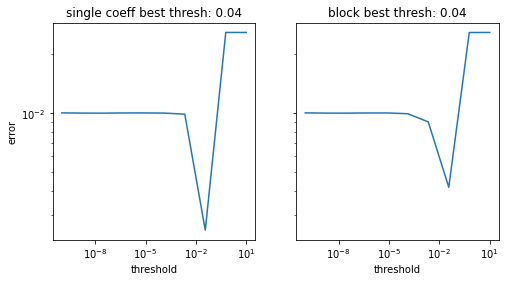

In [16]:
error_dict = {}
block_error_dict = {}
best_threshold_dict = {}
block_best_threshold_dict = {}
for noise_std in noise_std_array:
    
    error_dict[noise_std] = np.zeros_like(threshold_array);
    block_error_dict[noise_std] = np.zeros_like(threshold_array);
    
    for thresh_i, thresh in enumerate(threshold_array):
        total_error = 0.0;
        block_total_error = 0.0;
        total_length = 0.0;
        for i, x in enumerate(train_dataset):
            rec_source, rec_noisy, rec_denoised, rec_denoised_block = stft_denoising(x, noise_std, train_fs_array[i], nperseg, thresh, window_size,plot_res=False);
            total_error += np.linalg.norm( rec_denoised - rec_source)**2;
            block_total_error += np.linalg.norm( rec_denoised_block - rec_source)**2;
            total_length += len(rec_source);
            
        error_dict[noise_std][thresh_i] = (total_error/total_length);
        block_error_dict[noise_std][thresh_i] = (block_total_error/total_length);
        
    print('noise std: ', noise_std);
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (8, 4));
    
    axes[0].loglog(threshold_array, error_dict[noise_std])
    axes[0].set_xlabel('threshold')
    axes[0].set_ylabel('error')
        
    best_threshold_dict[noise_std] = threshold_array[np.argmin(error_dict[noise_std])]
    
    axes[0].set_title('single coeff best thresh: '+str( round(best_threshold_dict[noise_std], 2)) )
    
    axes[1].loglog(threshold_array, block_error_dict[noise_std])
    axes[1].set_xlabel('threshold')
#     axes[1].set_ylabel('error')
        
    block_best_threshold_dict[noise_std] = threshold_array[np.argmin(block_error_dict[noise_std])]
    
    axes[1].set_title('block best thresh: '+str( round(block_best_threshold_dict[noise_std], 2)) )
    
    plt.show()
    
    print('='*50+'\n')
        

### Comparison Between STFT Hard and Block Threshold

In [17]:
val_idx = 2

source = val_dataset[val_idx]
fs = val_fs_array[val_idx]
max_val = val_max_array[val_idx]


In [18]:
fig_size=(20,6)

Noise Std:  0.1


FileNotFoundError: [Errno 2] No such file or directory: 'plots/stft_denoising__clean_0_stft.pdf'

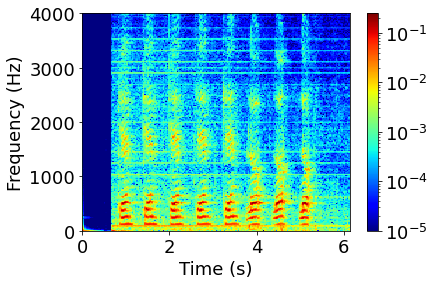

In [19]:
for ind_fig, noise_std in enumerate(noise_std_array):
    
    print('Noise Std: ', noise_std)
    
    noise_sample = get_noise(source, noise_std = noise_std);
    

    istft_source, istft_noisy, istft_denoised, istft_denoised_block = stft_denoising(source, noise_std, fs, nperseg,
                                                               thresh = best_threshold_dict[noise_std], 
                                                               window_size = window_size,
                                                               block_thresh = block_best_threshold_dict[noise_std])
    istft_denoised_block *= max_val
    istft_denoised *= max_val;
    istft_noisy *= max_val;
    istft_source *= max_val;
    
    print('STFT Denoised: ')
    IPython.display.display(ipd.Audio(istft_denoised, rate=fs))
    
    print('Block STFT Denoised: ')
    IPython.display.display(ipd.Audio(istft_denoised_block, rate=fs))
    
    label_size = 18
    font_size = 18
    
    t_indices = np.arange(len(istft_source))/fs
    
    plt.figure(figsize = fig_size)
    plt.plot(np.real(istft_source))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(istft_denoised[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    plt.savefig('plots/stft_stft_denoised_' + str(ind_fig) + '.pdf',bbox_inches="tight")
    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini:end],np.real(istft_denoised_block[ini:end]))
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    plt.savefig('plots/stft_block_denoised_' + str(ind_fig) + '.pdf',bbox_inches="tight")


   
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini2:end2],np.real(istft_source[ini2:end2]),'--o',markersize=6,lw=1.5,color='deepskyblue', label='Signal')
    plt.plot(t_indices[ini2:end2],np.real(istft_denoised[ini2:end2]),'x',color='tomato',markersize=8,mew=3, label='STFT thresholding')
    plt.plot(t_indices[ini2:end2],np.real(istft_noisy[ini2:end2]),'.',color='darkgreen',markersize=10,label='Noisy data')
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    plt.legend(fontsize=font_size)
    plt.savefig('plots/stft_stft_denoised_' + str(ind_fig) + '_zoom.pdf',bbox_inches="tight")
    
    plt.figure(figsize = fig_size)
    plt.plot(t_indices[ini2:end2],np.real(istft_source[ini2:end2]),'--o',markersize=6,lw=1.5,color='deepskyblue', label='Signal')
    plt.plot(t_indices[ini2:end2],np.real(istft_denoised_block[ini2:end2]),'x',color='tomato',markersize=8,mew=3, label='STFT block thresholding')
    plt.plot(t_indices[ini2:end2],np.real(istft_noisy[ini2:end2]),'.',color='darkgreen',markersize=10,label='Noisy data')
    plt.xlabel('Time (s)',fontsize=font_size)
    plt.tick_params(labelsize=label_size)
    plt.legend(fontsize=font_size)
    plt.savefig('plots/stft_block_denoised_' + str(ind_fig) + '_zoom.pdf',bbox_inches="tight")
    
    plt.show()
 
    
    print('='*50 + '\n')